### 3.3.2 - Deep Neural Network (DNN) model (with performance improvement)

*In order to improve the performance of the previous DNN model, a few strategies were applied.*

In [1]:
# Load the packages and other tools
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import shap
shap.initjs()
import pickle
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from scipy import stats
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from scalecast.Forecaster import Forecaster
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import optimizers
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tsmoothie.utils_func import sim_randomwalk
from tsmoothie.smoother import KalmanSmoother

C:\Users\sofia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\sofia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


#### Specific pre-processing to DL

In [181]:
# load data
model1 = pd.read_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/model/model.xlsx',index_col=0)

* Data Preparation

In [183]:
# Removing multicollinearity by dropping one of the variables in the pair
model1= model1.drop(['lg_Open','lg_Low','block-size'],axis=1)

In [184]:
# Removing variables with |corr|<0.3
model1= model1.drop(['lg_circulatingBTC','lg_Oil','lg_market-cap','News Regulation','Theft','lg_cost-per-transaction-percent','lg_output-volume'],axis=1)

In [187]:
# Creating the variables
for i in range(len(model1)+1):
    for j in range(0,19): 
        model1[str(model1.columns[j]+'_t-1')]=''
        model1[str(model1.columns[j]+'_t-2')]=''

In [188]:
# Filling with the respective values
for i in range(len(model1)):
    for j in range(0,19): 
        if i==0:
            model1[str(model1.columns[j]+'_t-1')][i]=model1[str(model1.columns[j])][i]
            model1[str(model1.columns[j]+'_t-2')][i]=model1[str(model1.columns[j])][i]
        if i==1:
            model1[str(model1.columns[j]+'_t-1')][i]=model1[str(model1.columns[j])][i-1]
            model1[str(model1.columns[j]+'_t-2')][i]=model1[str(model1.columns[j])][i-1]
        else: 
            model1[str(model1.columns[j]+'_t-1')][i]=model1[str(model1.columns[j])][i-1]
            model1[str(model1.columns[j]+'_t-2')][i]=model1[str(model1.columns[j])][i-2]

In [206]:
# Exporting the already prepared dataset
model1.to_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/DNN/tentativa.xlsx')

In [2]:
# Reading the Deep Learning (more specifically, DNN) dataset
dl=pd.read_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/DNN/tentativa.xlsx',index_col=0)

In [3]:
# Checking the first 2 rows
dl.head(2)

,lg_price,lg_trade-volume,lg_transaction-fees-usd,lg_avg-confirmation-time,lg_difficulty,lg_High,lg_hash-rate,lg_miners-revenue,n-transactions-total,lg_Popularity,...,lg_Gold_t-1,lg_Gold_t-2,GT_legal_t-1,GT_legal_t-2,GT_cryptocurrency_t-1,GT_cryptocurrency_t-2,GT_scam_t-1,GT_scam_t-2,lg_SP500_t-1,lg_SP500_t-2
Timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01,6.921086,15.376856,11.651582,2.566197,1.94591,6.921086,14.767149,14.575693,183961799.0,7,...,7.514565,7.514565,4.0,4.0,26,26,3,3,8.351962,8.351962
2017-01-02,6.921086,15.376856,11.651582,4.578962,1.94591,6.938963,14.767149,14.575693,183961799.0,7,...,7.083472,7.083472,1.0,1.0,2,2,1,1,7.729786,7.729786


* Noise smoothing with tsmoothie library

In [4]:
# Splitting 80% for training and 20% for testing
train = dl[:-323]
test = dl[-323:]
test=test.drop(['lg_price'], axis=1)


# Splitting 80% for training and 20% for validation
train = train[:-65]
len(train)
val = train[-65:]
len(test)

# prepare x_train, y_train
x_train = train.drop(['lg_price'], axis=1).values
y_train = train['lg_price'].values

# scaling
scale = MinMaxScaler(feature_range=(0,1))
x_train = scale.fit_transform(x_train)

# prepare x_test
x_test = test.values

# scaling
x_test = scale.transform(x_test)


# prepare x_val, y_val
x_val = val.drop(['lg_price'], axis=1).values
y_val = val['lg_price'].values

# scaling
from sklearn.preprocessing import MinMaxScaler
x_val = scale.fit_transform(x_val)

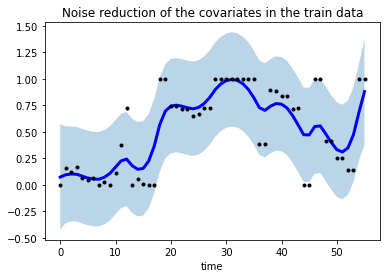

In [5]:
# operate smoothing
smoother = KalmanSmoother(component='level_trend', 
                          component_noise={'level':0.1, 'trend':0.1})
smoother.smooth(x_train)

# generate intervals
low, up = smoother.get_intervals('kalman_interval')

# plot the first smoothed timeseries with intervals
plt.plot(smoother.smooth_data[0], linewidth=3, color='blue') # blue line = smoothed data
plt.plot(smoother.data[0], '.k') # black points = original data
plt.xlabel('time')
plt.title('Noise reduction of the covariates in the train data')

plt.fill_between(range(len(smoother.data[0])), low[0], up[0], alpha=0.3)
plt.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/tent2_smoother_x_train.jpeg')

In [6]:
# Applying the smoother to x_train
x_train= smoother.smooth_data

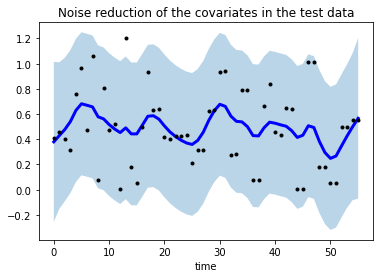

In [7]:
# operate smoothing
smoother = KalmanSmoother(component='level_trend', 
                          component_noise={'level':0.1, 'trend':0.1})
x_test=smoother.smooth(x_test)

# generate intervals
low, up = smoother.get_intervals('kalman_interval')

# plot the first smoothed timeseries with intervals
plt.plot(smoother.smooth_data[0], linewidth=3, color='blue')
plt.plot(smoother.data[0], '.k')
plt.xlabel('time')
plt.title('Noise reduction of the covariates in the test data')

plt.fill_between(range(len(smoother.data[0])), low[0], up[0], alpha=0.3)
x_test= smoother.smooth_data
plt.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/tent2_smoother_x_test.jpeg')

In [8]:
# Applying the smoother to x_test
x_test= smoother.smooth_data

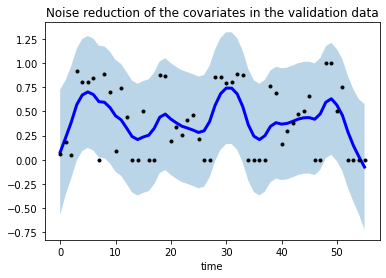

In [9]:
# operate smoothing
smoother = KalmanSmoother(component='level_trend', 
                          component_noise={'level':0.1, 'trend':0.1})
x_val=smoother.smooth(x_val)

# generate intervals
low, up = smoother.get_intervals('kalman_interval')

# plot the first smoothed timeseries with intervals
plt.plot(smoother.smooth_data[0], linewidth=3, color='blue')
plt.plot(smoother.data[0], '.k')
plt.xlabel('time')
plt.title('Noise reduction of the covariates in the validation data')

plt.fill_between(range(len(smoother.data[0])), low[0], up[0], alpha=0.3)
x_val= smoother.smooth_data
plt.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/tent2_smoother_x_val.jpeg')

In [10]:
# Applying the smoother to x_val
x_val= smoother.smooth_data

* Keras Hypertuning - Grid Search

In [216]:
def get_model(param):
        
    model = Sequential()
    model.add(Dense(param['unit_1'], activation=param['activ']))
    model.add(Dense(param['unit_2'], activation=param['activ']))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=param['lr']), 
                  loss='mse', metrics=['mse'])
    
    return model

In [217]:
from tensorflow.keras.optimizers import Adam
from kerashypetune import KerasGridSearch
param_grid = {
    'unit_1': [128,64], 
    'unit_2': [64,32],
    'lr': [1e-2,1e-3], 
    'activ': ['elu','relu'],
    'epochs': 100, 
    'batch_size': 512
}

kgs = KerasGridSearch(get_model, param_grid, monitor='val_loss', greater_is_better=False)
kgs.search(x_train, y_train, validation_data=(x_val, y_val))


16 trials detected for ('unit_1', 'unit_2', 'lr', 'activ', 'epochs', 'batch_size')

***** (1/16) *****
Search({'unit_1': 128, 'unit_2': 64, 'lr': 0.01, 'activ': 'elu', 'epochs': 100, 'batch_size': 512})
SCORE: 0.16411 at epoch 27

***** (2/16) *****
Search({'unit_1': 128, 'unit_2': 64, 'lr': 0.01, 'activ': 'relu', 'epochs': 100, 'batch_size': 512})
SCORE: 0.88104 at epoch 99

***** (3/16) *****
Search({'unit_1': 128, 'unit_2': 64, 'lr': 0.001, 'activ': 'elu', 'epochs': 100, 'batch_size': 512})
SCORE: 0.25767 at epoch 99

***** (4/16) *****
Search({'unit_1': 128, 'unit_2': 64, 'lr': 0.001, 'activ': 'relu', 'epochs': 100, 'batch_size': 512})
SCORE: 2.31383 at epoch 100

***** (5/16) *****
Search({'unit_1': 128, 'unit_2': 32, 'lr': 0.01, 'activ': 'elu', 'epochs': 100, 'batch_size': 512})
SCORE: 0.1672 at epoch 36

***** (6/16) *****
Search({'unit_1': 128, 'unit_2': 32, 'lr': 0.01, 'activ': 'relu', 'epochs': 100, 'batch_size': 512})
SCORE: 1.68585 at epoch 99

***** (7/16) *****
Search({'

In [218]:
kgs.scores

[0.16411,
 0.88104,
 0.25767,
 2.31383,
 0.1672,
 1.68585,
 0.33036,
 2.58888,
 0.16625,
 1.31051,
 0.29641,
 2.72438,
 0.15641,
 1.40794,
 0.9487,
 3.06286]

In [219]:
kgs.best_score

0.15641

In [220]:
# Saving the best model found as a new variable
best_model=kgs.best_model
best_model

In [ ]:
# Saving the results in the current fold
#best_model.save('best_model_tent2')

In [11]:
# Loading the best model
from keras.models import load_model
best_model= load_model('best_model_tent2')

In [12]:
# Predicting the values for lg_price
pred = best_model.predict(x_test)
print(pred[:5]) # Printing lg_price for the next 5 day to check if the values make sense
pred.shape

[[9.303387]
 [9.318356]
 [9.320208]
 [9.261264]
 [9.247763]]


(323, 1)

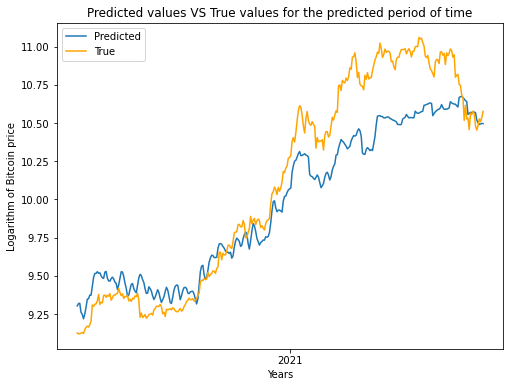

In [13]:
# Plotting the Predicted Bitcin price VS True Bitcoin price for the predicted period of time
original_test=dl.iloc[-323:,0]
date = original_test.index
fig, ax = plt.subplots(figsize=(8, 6))
year_locator = mdates.YearLocator()
ax.xaxis.set_major_locator(year_locator) # Locator for major axis only.
plt.plot(date, pred)
plt.plot(date, original_test,color='orange')
plt.title('Predicted values VS True values for the predicted period of time')
plt.xlabel('Years')
plt.ylabel('Logarithm of Bitcoin price')
plt.legend(['Predicted', 'True'])
plt.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/TENT2_DL_originalVSpred.jpeg')
plt.show()

In [14]:
from sklearn.metrics import mean_squared_error
actual_price = dl[-323:]['lg_price'].values

# 1. MSE - Mean Squared Error
MSE= mean_squared_error(actual_price,pred)
print("Mean Square Error: ", MSE)

# 2. RMSE - Root Mean Square Error
RMSE = math.sqrt(MSE)
print("Root Mean Square Error: ", RMSE)

# 3. sMAPE - symmetric Mean Absolute Percentage Error
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f)))
sMAPE=smape(actual_price,pred)
print('sMAPE: ',sMAPE)

# 4. R^2 score
r2_score = metrics.r2_score(actual_price,pred)
print('R^2 score: ',r2_score)

Mean Square Error:  0.0648094055883218
Root Mean Square Error:  0.2545769148770599
sMAPE:  22.05052242781754
R^2 score:  0.855801611840608


In [ ]:
# Reading the dataset with the latest models' performance
metric=pd.read_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/metrics/metrics.xlsx',index_col=0)
metric.head(5)

In [238]:
# Defining a dictionary
d = {'Model': 'DNN2','MSE': MSE,'RMSE':RMSE,'sMAPE':sMAPE,'R^2 score': r2_score}

# Adding the most recent results to the existing dataframe
metric = metric.append(d, ignore_index=True)
metric.to_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/metrics/metrics.xlsx')

In [239]:
metric.head()

,Model,MSE,RMSE,sMAPE,R^2 score
0,GLS,0.016803,0.129628,0.009797,0.962613
1,LSTM,0.028533,0.168918,24.519984,0.936515
2,DNN,0.263678,0.513496,23.335937,0.413326
3,DNN2,0.064809,0.254577,22.050522,0.855802


In [240]:
# Displaying the previous dataset with 'Model' as an index
metric=pd.read_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/metrics/metrics.xlsx',index_col=1)
metric=metric.drop(['Unnamed: 0'],axis=1)
metric.head()

,MSE,RMSE,sMAPE,R^2 score
Model,,,,
GLS,0.016803,0.129628,0.009797,0.962613
LSTM,0.028533,0.168918,24.519984,0.936515
DNN,0.263678,0.513496,23.335937,0.413326
DNN2,0.064809,0.254577,22.050522,0.855802


## 4. EXPLAINABLE AI: SHAP

*In order to understand what features led to the prediction values, a explainable AI techquine, concretelly, SHAP will be applied.* 

**(A) - Global Interpretability: Variable Importance**

In [15]:
# compute SHAP values
explainer = shap.DeepExplainer(best_model, x_test)
shap_values = explainer.shap_values(x_test)

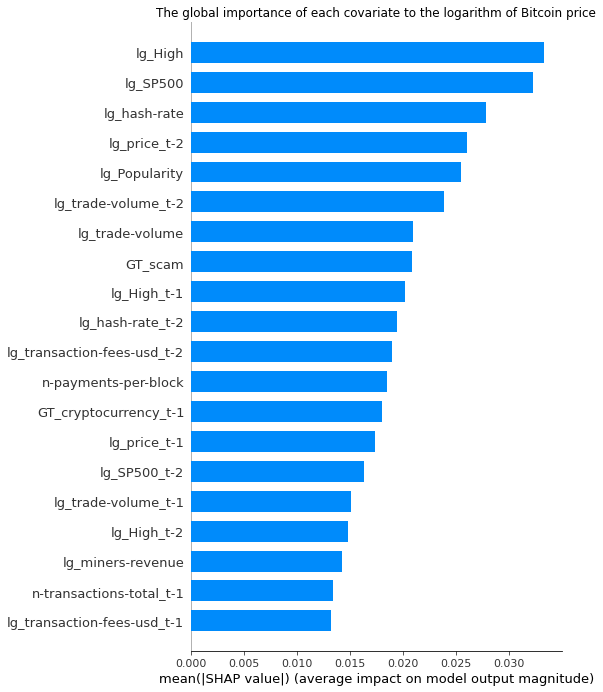

In [35]:
shap.summary_plot(shap_values[0], plot_type = 'bar', feature_names = test.columns,show=False)
plt.title('The global importance of each covariate to the logarithm of Bitcoin price')

f = plt.gcf()

In [260]:
f.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/tent2_DL_shap.jpeg',bbox_inches='tight',pad_inches=0.25)

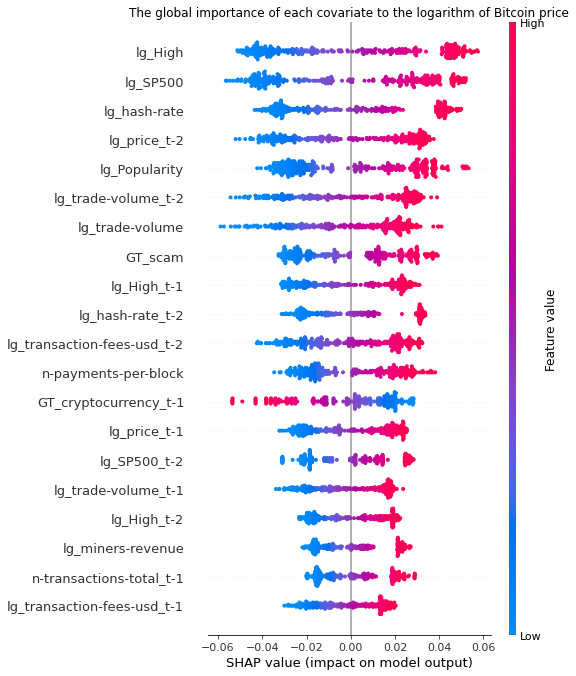

In [36]:
f = plt.figure()
plt.title('The global importance of each covariate to the logarithm of Bitcoin price')

shap.summary_plot(shap_values[0], x_test,feature_names = test.columns)
f.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/SHAP2.jpeg', bbox_inches='tight', dpi=600)

**(A) - Global Interpretability: Partial dependence**

<Figure size 432x288 with 0 Axes>

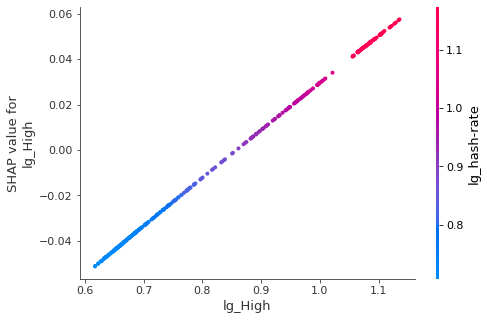

In [45]:
f=plt.figure()
shap.dependence_plot("lg_High", shap_values[0], x_test,feature_names = test.columns)
f.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/SHAP_lg_high.jpeg', bbox_inches='tight', dpi=600)

<Figure size 432x288 with 0 Axes>

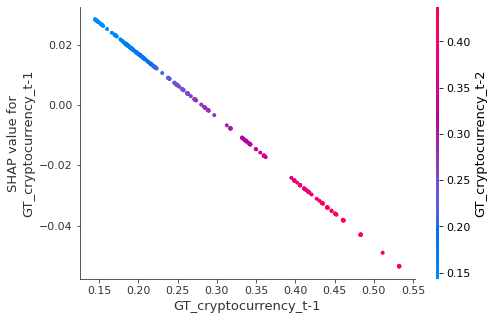

In [39]:
f=plt.figure()
shap.dependence_plot("GT_cryptocurrency_t-1", shap_values[0], x_test,feature_names = test.columns)
f.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/SHAP_lg_cryp_t-1.jpeg', bbox_inches='tight', dpi=600)

**(B) - Local Interpretability**

In [82]:
# Select the top 10 most relevant features
most_rel=['lg_High','lg_SP500','lg_hash-rate','lg_price_t-2','lg_Popularity','lg_trade-volume_t-2','lg_trade-volume','GT_scam','lg_High_t-1','lg_hash-rate_t-2']

# Get the predictions and put them with the test data
x_output = test.copy()
x_output=x_output[most_rel]
x_output['predictions'] = ''
x_output['predictions'] = pred
x_output.iloc[169:174,:] # checking the first 5 days of 2021

,lg_High,lg_SP500,lg_hash-rate,lg_price_t-2,lg_Popularity,lg_trade-volume_t-2,lg_trade-volume,GT_scam,lg_High_t-1,lg_hash-rate_t-2,predictions
Timestamp,,,,,,,,,,,
2021-01-01,10.296445,8.24111,18.741053,10.217436,42,20.186396,20.223255,5,10.285302,18.884601,10.068834
2021-01-02,10.411314,8.24111,18.754386,10.270094,42,20.436972,20.012480,5,10.296445,18.849094,10.075106
2021-01-03,10.456105,8.24111,18.799702,10.274450,65,20.223255,21.055376,6,10.411314,18.741053,10.177970
2021-01-04,10.421909,8.24111,18.890398,10.288537,65,20.012480,20.698800,6,10.456105,18.754386,10.220261
2021-01-05,10.446239,8.24111,18.793352,10.379581,65,21.055376,21.082347,6,10.421909,18.799702,10.250202


In [81]:
# Plotting the values for 1st January 2021
shap.initjs()
shap.force_plot(explainer.expected_value[0].numpy(), shap_values[0][169], features = test.columns)

In [121]:
#plt.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/DL_shap1.jpeg',bbox_inches='tight',pad_inches=0.25)

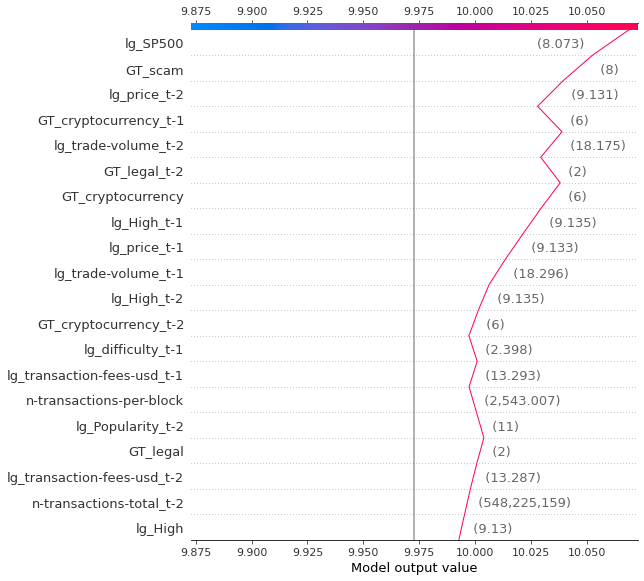

<Figure size 432x288 with 0 Axes>

In [120]:
shap.decision_plot(explainer.expected_value[0].numpy(), shap_values[0][169], features = test.iloc[0,:], feature_names = test.columns.tolist())
f = plt.gcf()
#f.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/DL_shap2.jpeg',bbox_inches='tight',pad_inches=0.25)

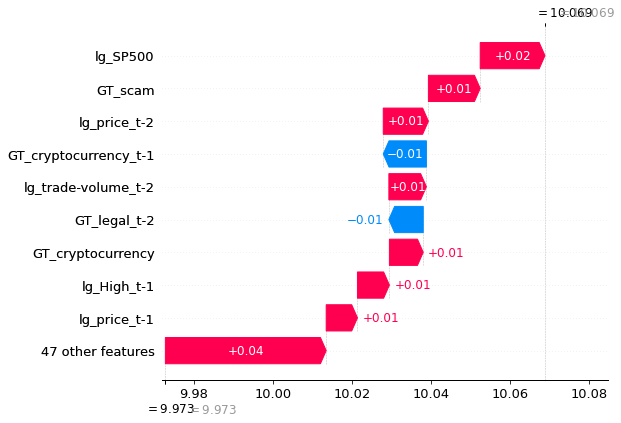

In [111]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0].numpy(), shap_values[0][169], feature_names = test.columns)

*Note: all the data analysis is provided in the thesis.*